# Result Analysis for Deephyper Graph Neural Network
### Author: Shengli Jiang (sjiang87@wisc.edu)

### Datasets: QM7, QM8, QM9, ESOL, FreeSolv, Lipophilicity

In [63]:
import json
import glob
import pickle
from tabulate import tabulate
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def to_sec(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').timestamp()
    except:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f').timestamp()

sns.set()
sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

### 1 Generate reward vs time figure

In [25]:
def plot_reward_vs_time(data, PLOT_DIR):
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    x = times
    y = data['raw_rewards']
    plt.figure(figsize=(8.5, 6))

    plt.plot(x, y, 'o', markersize=3)
    plt.ylabel('Reward (-MAE)')
    plt.xlabel('Time (sec)')

    plt.xlim(left=0)
    plt.locator_params(axis='y', nbins=6)
    plt.savefig(PLOT_DIR+'reward.png', dpi=300)

### 2.1 Three random split data results

In [96]:
def three_random_split(DATA_DIR, multi_class=False):
    y_true = []
    y_pred = []
    files = sorted(glob.glob(DATA_DIR + 'best_archs_result_0_*.pickle'))
    for file in files:
        with open(file, 'rb') as f:
            _ = pickle.load(f)
            for _ in range(3):
                if multi_class:
                    y_true.append(pickle.load(f)[np.newaxis, ...])
                    y_pred.append(pickle.load(f).squeeze()[np.newaxis, ...])
                else:
                    y_true.append(pickle.load(f).ravel())
                    y_pred.append(pickle.load(f).ravel().squeeze())
    train_true = np.vstack([y_true[i] for i in [0, 3, 6]])
    train_pred = np.vstack([y_pred[i] for i in [0, 3, 6]])
    valid_true = np.vstack([y_true[i] for i in [1, 4, 7]])
    valid_pred = np.vstack([y_pred[i] for i in [1, 4, 7]])
    test_true = np.vstack([y_true[i] for i in [2, 5, 8]])
    test_pred = np.vstack([y_pred[i] for i in [2, 5, 8]])
    return train_true, train_pred, valid_true, valid_pred, test_true, test_pred

### 2.2 Three random split data mean and standard deviation

In [161]:
def three_random_mean_std(DATA_DIR, multi_class=False):
    output = three_random_split(DATA_DIR, multi_class=multi_class)
    funcs = [mean_absolute_error, mean_squared_error, r2_score]
    
    if not multi_class:
        result = []
        for func in funcs:
            for i in range(3):
                result.append([func(output[i*2][j], output[i*2+1][j]) for j in range(len(train_true))])
        result = np.array(result)
        m = result.mean(axis=1)
        s = result.std(axis=1)
        print(tabulate([['Train', f'{m[0]:0.4f}+/-{s[0]:0.4f}', f'{m[3]:0.4f}+/-{s[3]:0.4f}', f'{m[6]:0.4f}+/-{s[6]:0.4f}'], 
                        ['Valid', f'{m[1]:0.4f}+/-{s[1]:0.4f}', f'{m[4]:0.4f}+/-{s[4]:0.4f}', f'{m[7]:0.4f}+/-{s[7]:0.4f}'],
                        ['Test', f'{m[2]:0.4f}+/-{s[2]:0.4f}', f'{m[5]:0.4f}+/-{s[5]:0.4f}', f'{m[8]:0.4f}+/-{s[8]:0.4f}']],
                       headers=['', 'MAE', 'MSE', 'R2']))
    else:
        for c in range(output[0].shape[-1]):
            result = []
            for func in funcs:
                for i in range(3):
                    result.append([func(output[i*2][j, :, c], output[i*2+1][j, :, c]) for j in range(len(train_true))])
            result = np.array(result)
            m = result.mean(axis=1)
            s = result.std(axis=1)
            print(tabulate([['Train', f'{m[0]:0.4f}+/-{s[0]:0.4f}', f'{m[3]:0.4f}+/-{s[3]:0.4f}', f'{m[6]:0.4f}+/-{s[6]:0.4f}'], 
                            ['Valid', f'{m[1]:0.4f}+/-{s[1]:0.4f}', f'{m[4]:0.4f}+/-{s[4]:0.4f}', f'{m[7]:0.4f}+/-{s[7]:0.4f}'],
                            ['Test', f'{m[2]:0.4f}+/-{s[2]:0.4f}', f'{m[5]:0.4f}+/-{s[5]:0.4f}', f'{m[8]:0.4f}+/-{s[8]:0.4f}']],
                           headers=['', 'MAE', 'MSE', 'R2']))
    return m, s

### 2.3 Three random split data parity plot

In [150]:
def three_random_parity_plot(DATA_DIR, PLOT_DIR, multi_class=False, limits=None):
    _, _, _, _, y_true_raw, y_pred_raw = three_random_split(DATA_DIR, multi_class=multi_class)
    if not multi_class:
        y_true = y_true_raw.ravel()
        y_pred = y_pred_raw.ravel()
        plt.figure(figsize=(8,6))
        min_value = np.min([y_true.min(), y_pred.min()])
        max_value = np.max([y_true.max(), y_pred.max()])
        dist = max_value - min_value
        min_value -= 0.03*dist
        max_value += 0.03*dist
        if limits is not None:
            min_value, max_value = limits
        plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
        plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.axis("square")
        plt.locator_params(axis='x', nbins=5)
        plt.locator_params(axis='y', nbins=5)
        plt.savefig(PLOT_DIR + "parity_plot.png")
    else:
        for c in range(y_true_raw.shape[-1]):
            y_true = y_true_raw[..., c].ravel()
            y_pred = y_pred_raw[..., c].ravel()
            plt.figure(figsize=(8,6))
            min_value = np.min([y_true.min(), y_pred.min()])
            max_value = np.max([y_true.max(), y_pred.max()])
            dist = max_value - min_value
            min_value -= 0.03*dist
            max_value += 0.03*dist
            if limits is not None:
                min_value, max_value = limits
            plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
            plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
            plt.xlim(min_value, max_value)
            plt.ylim(min_value, max_value)
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.axis("square")
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=5)
            plt.savefig(PLOT_DIR + f"parity_plot_{c}.png")

### 3.1 Search space to csv file

In [76]:
state_dims = [8, 16, 32]
Ts = [1, 2, 3]
attn_methods = ['const', 'gcn', 'gat', 'sym-gat']
attn_heads = [1, 2, 4, 6]
aggr_methods = ['max', 'mean', 'sum']
update_methods = ['gru', 'mlp']
activations = ['sigmoid', 'tanh', 'relu', 'elu']
out = []
for state_dim in state_dims:
    for T in Ts:
        for attn_method in attn_methods:
            for attn_head in attn_heads:
                for aggr_method in aggr_methods:
                    for update_method in update_methods:
                        for activation in activations:
                            out.append([state_dim, T, attn_method, attn_head, aggr_method, update_method, activation])

out_pool = []
for functions in ['GlobalSumPool', 'GlobalMaxPool', 'GlobalAvgPool']:
    for axis in ['-1', '-2']:  # Pool in terms of nodes or features
        out_pool.append(functions+axis)
out_pool.append('flatten')

out_connect = ['skip', 'connect']

def get_gat(index):
    return out[index]
def get_pool(index):
    return out_pool[index]
def get_connect(index):
    return out_connect[index]

def create_csv(DATA_DIR, data):
    archs = np.array(data['arch_seq'])
    rewards = np.array(data['raw_rewards'])
    a = np.empty((len(archs),0), dtype=np.object)
    a = np.append(a, archs, axis=-1)
    a = np.append(a, rewards[..., np.newaxis], axis=-1)
    b = np.empty((0,29), dtype=np.object)
    for i in range(len(a)):
        temp = a[i, :]
        b0 = get_gat(temp[0])
        b1 = [get_connect(temp[1])]
        b2 = get_gat(temp[2])
        b3 = [get_connect(temp[3])]
        b4 = [get_connect(temp[4])]
        b5 = get_gat(temp[5])
        b6 = [get_connect(temp[6])]
        b7 = [get_connect(temp[7])]
        b8 = [get_connect(temp[8])]
        b9 = [get_pool(temp[9])]
        bout = b0+b1+b2+b3+b4+b5+b6+b7+b8+b9+[temp[10]]
        bout = np.array(bout, dtype=object)
        b = np.append(b, bout[np.newaxis, ...], axis=0)
    table = pd.DataFrame(data=b)
    table.to_csv(DATA_DIR + 'nas_result.csv', encoding='utf-8', index=False, header=False)

### 3.1 CSV file to feature importance

In [177]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    df_new.columns = [                'dim-1',                 'pass-1',           'const-1',
                   'gat-1',             'gcn-1',         'sym-gat-1',
                       'head-1',             'max-1',            'mean-1',
                   'sum-1',             'gru-1',             'mlp-1',
                   'elu-1',            'relu-1',         'sigmoid-1',
                  'tanh-1',         'connect-1',            'skip-1',
                       'dim-2',                 'pass-2',           'const-2',
                   'gat-2',             'gcn-2',         'sym-gat-2',
                      'sym-gat-2',             'max-2',            'mean-2',
                   'sum-2',             'gru-2',             'mlp-2',
                   'elu-2',            'relu-2',         'sigmoid-2',
                  'tanh-2',         'connect-2',            'skip-2',
               'connect-3',            'skip-3',                'dim-3',
                      'pass-3',           'const-3',             'gat-3',
                   'gcn-3',         'sym-gat-3',                'head-3',
                   'max-3',            'mean-3',             'sum-3',
                   'gru-3',             'mlp-3',             'elu-3',
                  'relu-3',         'sigmoid-3',            'tanh-3',
               'connect-4',            'skip-4',         'connect-5',
                  'skip-5',         'connect-6',            'skip-6',
       'GlobalAvgPool-1', 'GlobalAvgPool-2', 'GlobalMaxPool-1',
       'GlobalMaxPool-2', 'GlobalSumPool-1', 'GlobalSumPool-2',
               'flatten',                'reward']
    X,y = df_new.values[:,0:66], df_new.values[:,67]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(12,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    print(df.values[np.argmax(y),:])

### 4.1 MoleculeNet vs Deephyeper

In [169]:
def mol_vs_deep(DATA_DIR, PLOT_DIR, mol_m, mol_s, metric='MAE'):
    m, s = three_random_mean_std(DATA_DIR=DATA_DIR)
    labels = ["Train", "Valid", "Test"]
    if metric is 'MAE':
        m = m[:3]
        s = s[:3]
    if metric is 'MSE':
        m = m[3:6]
        s = s[3:6]
    plt.figure()
    plt.barh([0.25,-1.75,-3.75], m, color="maroon", align='center', height=0.5, label="Deephyper", xerr=s, capsize=5)
    plt.barh([-0.25,-2.25,-4.25], mol_m, color="gray", align='center', height=0.5, label="MoleculeNet", xerr=mol_s, capsize=5)
    plt.yticks([0,-2,-4], labels)
    plt.xlabel(f"{metric}")
    plt.legend(loc=1)
    plt.savefig(PLOT_DIR + f"{metric}_compare.png", dpi=300)

# QM7

In [71]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/qm7/"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0708/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-08_18.json')

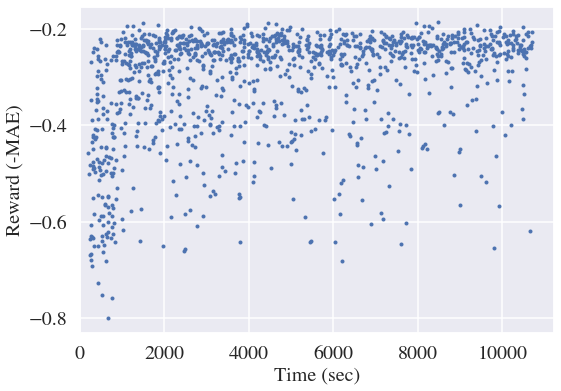

In [72]:
plot_reward_vs_time(QM7_data, QM7_PLOT_DIR)

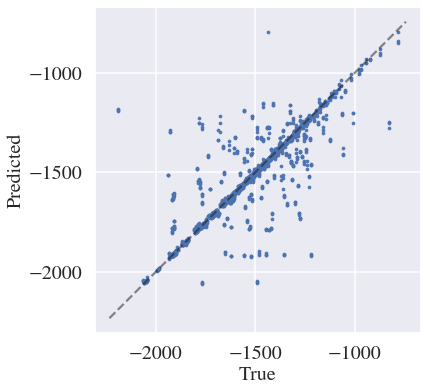

In [146]:
three_random_parity_plot(QM7_DATA_DIR, QM7_PLOT_DIR)

[32 1 'gcn' 2 'max' 'mlp' 'relu' 'connect' 32 2 'const' 4 'mean' 'gru'
 'tanh' 'skip' 'connect' 32 2 'const' 1 'sum' 'gru' 'elu' 'connect' 'skip'
 'connect' 'GlobalSumPool-2' -0.18447165191173556]


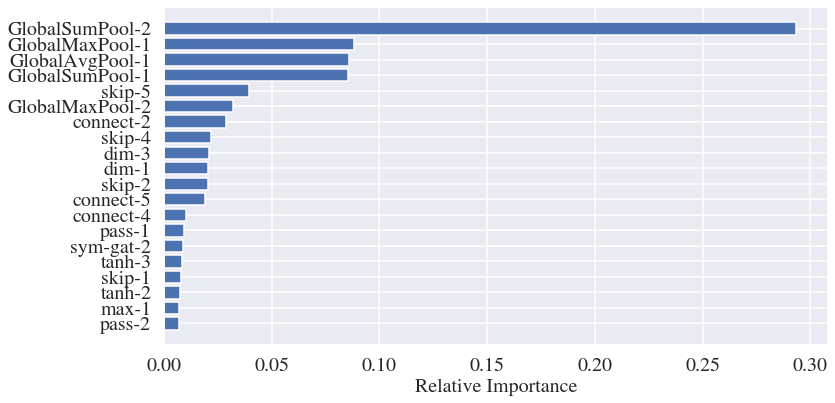

In [178]:
create_csv(QM7_DATA_DIR, QM7_data)
feature_importance(QM7_DATA_DIR, QM7_PLOT_DIR)

       MAE               MSE                    R2
-----  ----------------  ---------------------  ---------------
Train  39.6657+/-0.9336  11737.5352+/-88.8649   0.7609+/-0.0018
Valid  35.4343+/-0.4272  9454.5605+/-160.2698   0.8070+/-0.0033
Test   45.1978+/-1.0501  13369.0819+/-236.9001  0.7261+/-0.0049


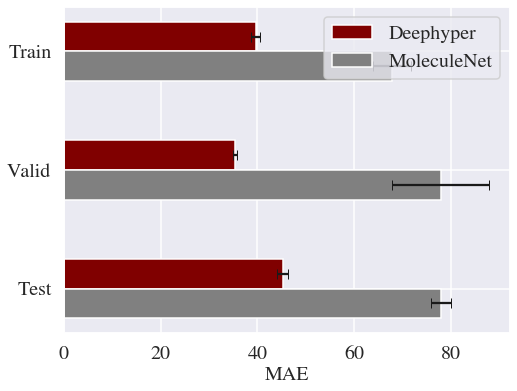

In [170]:
mol_vs_deep(QM7_DATA_DIR, QM7_PLOT_DIR, [67.8, 77.9, 77.9], [4.0, 10.0, 2.1], metric='MAE')

# QM8

In [81]:
QM8_PLOT_DIR = r"/mnt/d/plots/anl/qm8/"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0708/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-08_14.json')

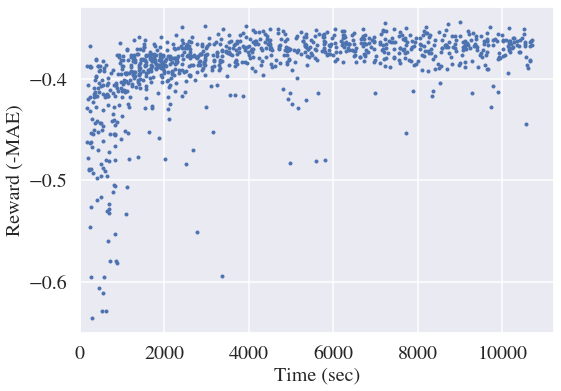

In [88]:
plot_reward_vs_time(QM8_data, QM8_PLOT_DIR)

In [89]:
three_random_mean_std(QM8_DATA_DIR)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0117+/-0.0000  0.0008+/-0.0000  0.9390+/-0.0003
Valid  0.0122+/-0.0000  0.0008+/-0.0000  0.9351+/-0.0012
Test   0.0124+/-0.0000  0.0009+/-0.0000  0.9320+/-0.0001


In [104]:
three_random_mean_std(QM8_DATA_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0061+/-0.0001  0.0001+/-0.0000  0.9587+/-0.0014
Valid  0.0065+/-0.0001  0.0001+/-0.0000  0.9482+/-0.0029
Test   0.0063+/-0.0000  0.0001+/-0.0000  0.9589+/-0.0004
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0080+/-0.0001  0.0001+/-0.0000  0.8915+/-0.0022
Valid  0.0082+/-0.0000  0.0001+/-0.0000  0.8814+/-0.0036
Test   0.0082+/-0.0002  0.0001+/-0.0000  0.8854+/-0.0071
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0123+/-0.0001  0.0011+/-0.0000  0.6182+/-0.0093
Valid  0.0129+/-0.0002  0.0012+/-0.0000  0.6274+/-0.0090
Test   0.0130+/-0.0001  0.0012+/-0.0000  0.5407+/-0.0131
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0286+/-0.0000  0.0032+/-0.0000  0.4135+/-0.0068
Valid  0.0291+/-0.0001  0.

[32 1 'gcn' 2 'sum' 'gru' 'tanh' 'connect' 16 2 'gat' 2 'mean' 'mlp' 'elu'
 'connect' 'skip' 32 3 'sym-gat' 6 'sum' 'mlp' 'tanh' 'connect' 'skip'
 'connect' 'GlobalMaxPool-2' -0.34357380867004395]


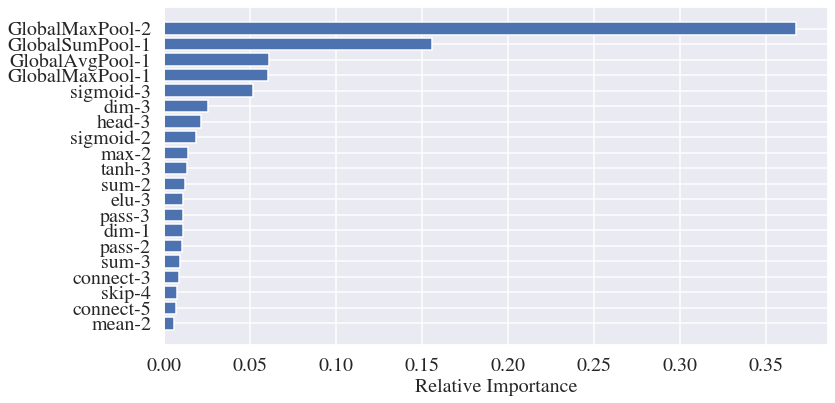

In [180]:
create_csv(QM8_DATA_DIR, QM8_data)
feature_importance(QM8_DATA_DIR, QM8_PLOT_DIR)

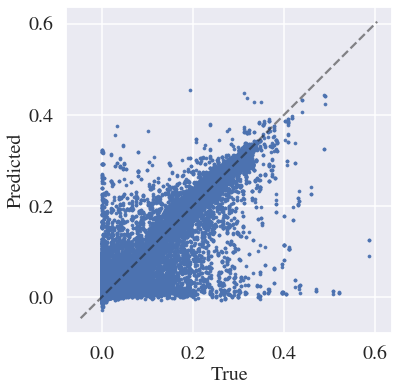

In [153]:
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR)

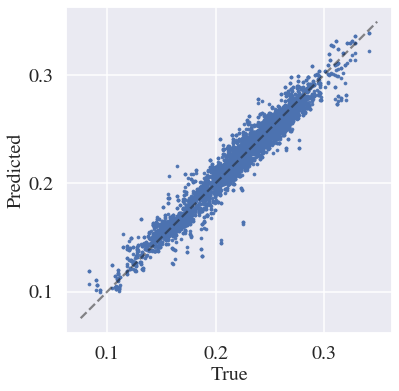

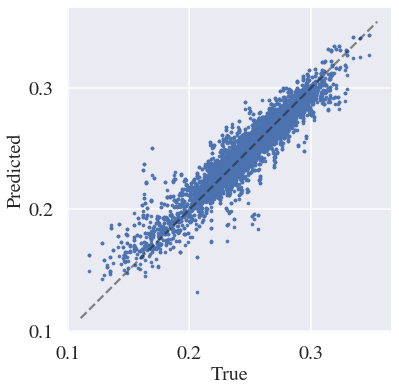

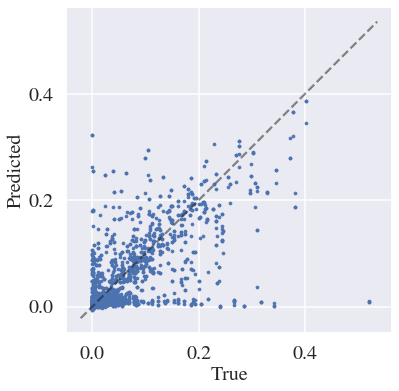

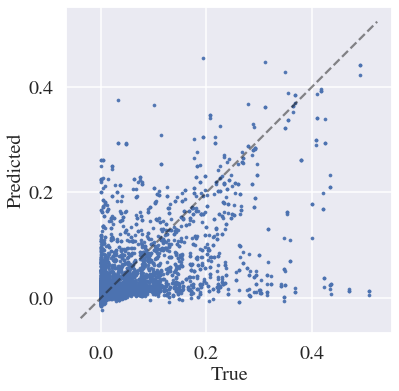

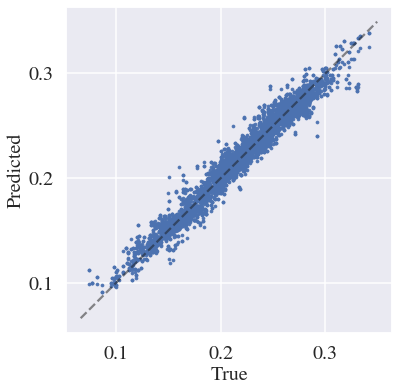

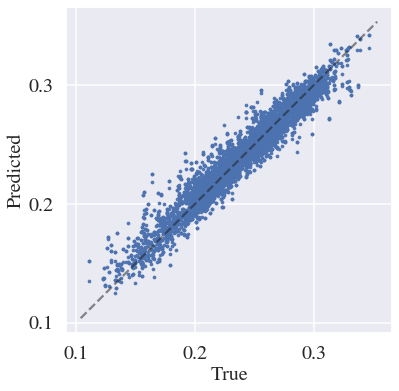

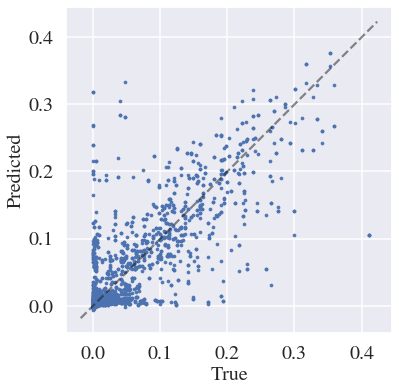

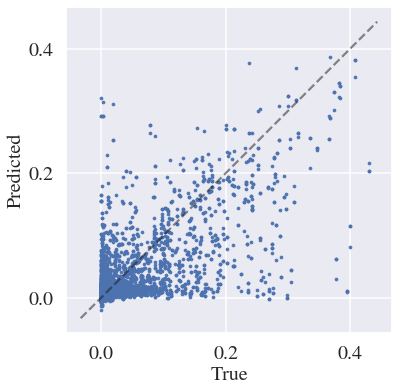

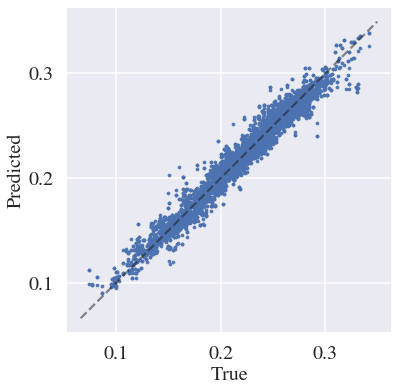

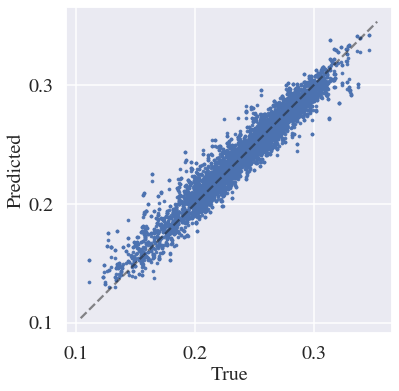

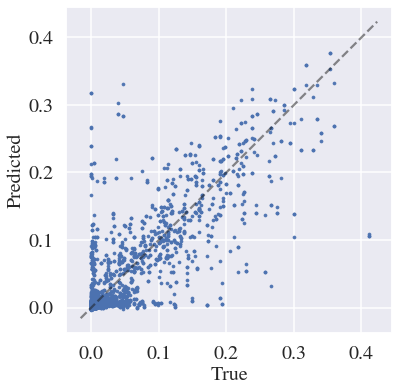

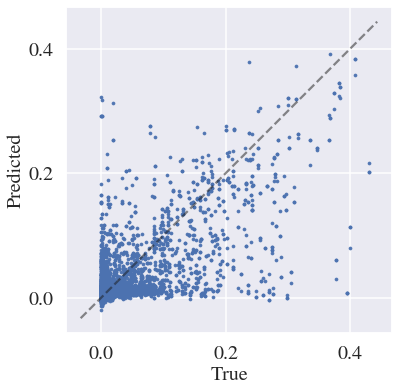

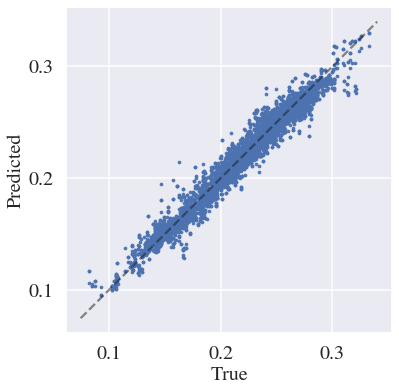

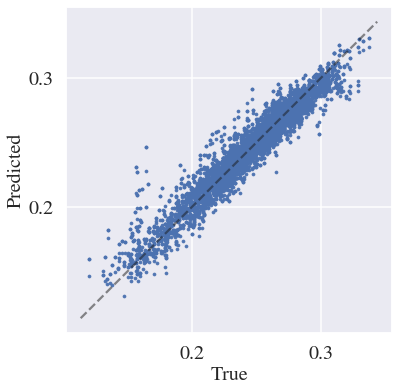

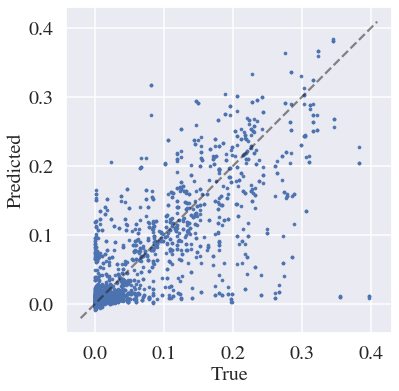

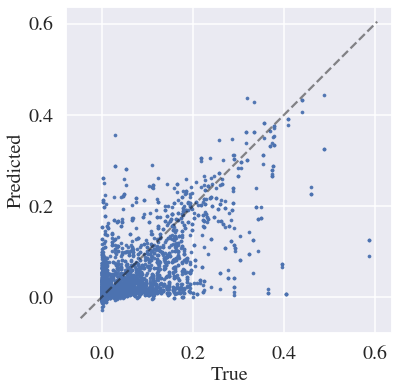

In [148]:
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0117+/-0.0000  0.0008+/-0.0000  0.9390+/-0.0003
Valid  0.0122+/-0.0000  0.0008+/-0.0000  0.9351+/-0.0012
Test   0.0124+/-0.0000  0.0009+/-0.0000  0.9320+/-0.0001


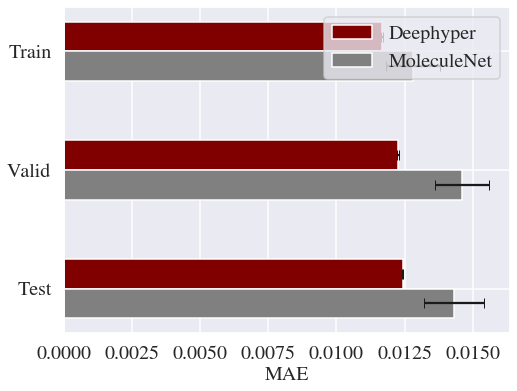

In [179]:
mol_vs_deep(QM8_DATA_DIR, QM8_PLOT_DIR, [0.0128, 0.0146, 0.0143], [0.001, 0.001, 0.0011], metric='MAE')

### ESOL

In [136]:
ESOL_PLOT_DIR = r"/mnt/d/plots/anl/ESOL/"
ESOL_DATA_DIR = r"/mnt/d/machinelearning2/ANL/ESOL/run_0714/"
ESOL_data = load_json(ESOL_DATA_DIR + 'data_2020-07-14_18.json')

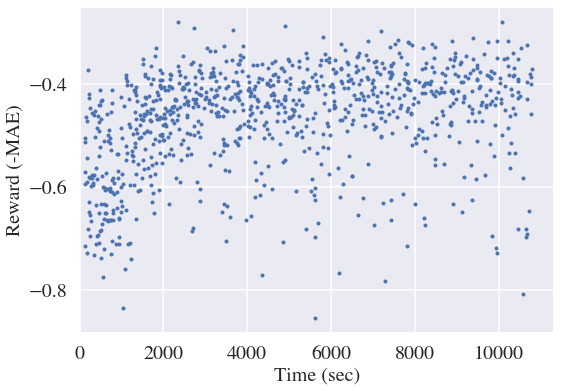

In [137]:
plot_reward_vs_time(ESOL_data, ESOL_PLOT_DIR)

### FreeSolv

In [138]:
FreeSolv_PLOT_DIR = r"/mnt/d/plots/anl/FreeSolv/"
FreeSolv_DATA_DIR = r"/mnt/d/machinelearning2/ANL/FreeSolv/run_0708/"
FreeSolv_data = load_json(FreeSolv_DATA_DIR + 'data_2020-07-14_14.json')

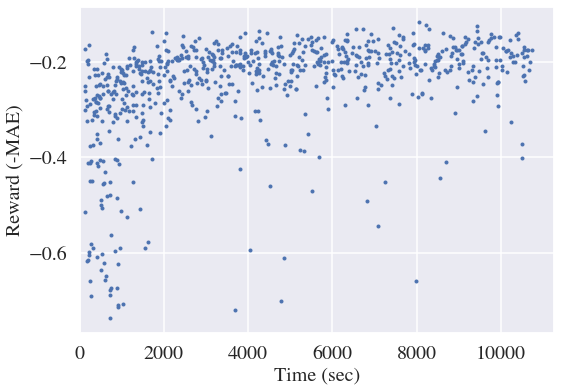

In [139]:
plot_reward_vs_time(FreeSolv_data, FreeSolv_PLOT_DIR)

In [140]:
three_random_mean_std(FreeSolv_DATA_DIR)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.4564+/-0.0881  0.4236+/-0.1582  0.9709+/-0.0109
Valid  0.5094+/-0.0672  0.4885+/-0.1181  0.9719+/-0.0068
Test   0.6582+/-0.0541  1.0396+/-0.1809  0.9217+/-0.0136


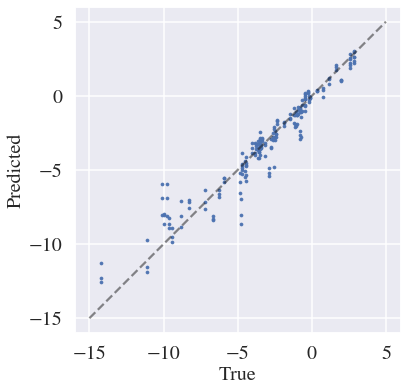

In [154]:
three_random_parity_plot(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, limits=(-15, 5))

[32 1 'const' 6 'max' 'mlp' 'tanh' 'skip' 16 3 'const' 1 'max' 'mlp'
 'relu' 'connect' 'connect' 32 3 'gat' 6 'max' 'mlp' 'tanh' 'connect'
 'skip' 'connect' 'GlobalAvgPool-2' -0.11666294932365415]


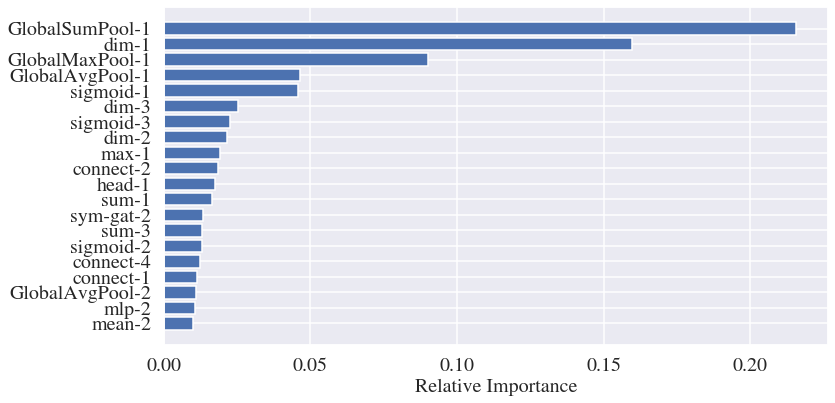

In [181]:
create_csv(FreeSolv_DATA_DIR, FreeSolv_data)
feature_importance(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.4564+/-0.0881  0.4236+/-0.1582  0.9709+/-0.0109
Valid  0.5094+/-0.0672  0.4885+/-0.1181  0.9719+/-0.0068
Test   0.6582+/-0.0541  1.0396+/-0.1809  0.9217+/-0.0136


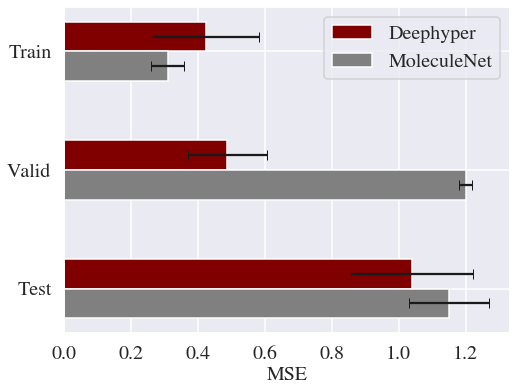

In [183]:
mol_vs_deep(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, [0.31, 1.20, 1.15], [0.05, 0.02, 0.12], metric='MSE')